# 데이터 불러오기

In [1]:
from konlpy.tag import Mecab 
import MeCab
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import networkx as nx
import ast
import matplotlib.font_manager as fm
import platform

In [2]:
df = pd.read_csv('./네이버쇼핑몰 칫솔-동호/네이버 쇼핑몰 칫솔 전처리완료-동호.csv',index_col=0)

In [3]:
df = df.drop_duplicates(['내용'])  # 동일한 내용글 삭제
df = df.reset_index(drop=True)
df

,내용,날짜,별점,재구매,한달사용기,종류
0,일반형은 확실히 뻣뻣하구요 슬림형이 부드럽구 좋아요 전 한달만사용하구 바로바로 교체...,2019-07-03,4,0,1,3
1,어금니일반형 우연히치과에서 써보구좋아 찾아보니 파네요 아이들 이관리해주기 딱좋은 ...,2019-07-04,5,0,0,4
2,저번에 구매 하였다가 잃어버려서 다시 구매 하였어요! 교정중인데 구석구석 잘 닦이구...,2019-07-08,5,1,0,4
3,칫솔모가 가늘면서도 짱짱해요^^ 기존엔 시스테마등을 사용했는데 전 이곳 칫솔이 훨씬...,2019-07-09,5,0,0,1
4,온가족의 이를 책임지네요ㅎㅎ 이거써본후로는 여기서만 사요 강추,2019-07-14,5,0,0,2
...,...,...,...,...,...,...
44955,헤드가 좀 크지만 좋아요,2022-05-09,5,0,0,4
44956,배송빠릅니다 물건좋습니다,2022-05-09,5,0,0,2
44957,중학교 다니는 애가 최근에 교정해서 구입해 사용중인데 만족합니다.,2022-05-09,5,0,1,1
44958,배송도 빠르고 저렴한 가격으로 좋아요,2022-05-09,4,0,0,3


In [4]:
#결측값 확인
df.isna().sum()

내용       0
날짜       0
별점       0
재구매      0
한달사용기    0
종류       0
dtype: int64

# 자연어처리

### mecab 사용자정의사전

In [5]:
# 불용어 지정
stop_words=['달','사용','개','칫솔','거','배송','구매','구석구석','중','것','여기','수','때','게','하나','시작','후','양치',
'번','닦','데','미','듯','전','날','끝','천','원','치','앞','날','저','쪽','이','분','건','제','나','년','쭉','톤','편','일','만',
'걸','여','곳','담','둘','질','점','줄','간','꺼','시','삿','합','입','당','오','통','주','내','ㄷ','렴','갯','말','형','께','ㅅ',
'상','템','돔','모라','조','컷','갑','ㄱ','구','ㅈ','차','지','ㄴ','면','겨','감','사','인','히','중미','중모']

In [6]:
with open("C:/mecab/user-dic/nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines()
file_data

['일반모,,,,NNP,*,F,일반모,*,*,*,*,*\n',
 '미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n',
 '가성비,,,,NNP,*,F,가성비,*,*,*,*,*\n',
 '미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n',
 '리뉴얼,,,,NNP,*,T,리뉴얼,*,*,*,*,*\n']

In [7]:
# file_data.append('미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n')   # 원하는 단어를 더할 때 사용할 것
# file_data.append('가성비,,,,NNP,*,F,가성비,*,*,*,*,*\n')
# file_data.append('미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n')
# file_data.append('리뉴얼,,,,NNP,*,T,리뉴얼,*,*,*,*,*\n')
with open("C:/mecab/user-dic/nnp.csv", 'w', encoding='utf-8') as f: 
    for line in file_data :
        f.write(line)
f.close()
file_data

['일반모,,,,NNP,*,F,일반모,*,*,*,*,*\n',
 '미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n',
 '가성비,,,,NNP,*,F,가성비,*,*,*,*,*\n',
 '미세모,,,,NNP,*,F,미세모,*,*,*,*,*\n',
 '리뉴얼,,,,NNP,*,T,리뉴얼,*,*,*,*,*\n']

* 이후 윈도우 powershell에서 관리자 권한으로 실행

--> cd C:\mecab 

--> .\tools\add-userdic-win.ps1 을 타이핑한 뒤 사용자사전 업데이트

막힐시 Set-ExecutionPolicy Unrestricted를 통해 잠시 풀고, 진행완료 후 원상복귀.

### mecab을 통해 토큰화

In [8]:
from konlpy.tag import Mecab
tagger = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

nouns = []
all_token=[]

for i in df['내용']:
    noun=[]                             # noun에 df['내용']에 있는 댓글들의 명사 추출후 삽입
    for x in tagger.nouns(i):
        if x not in stop_words:
            noun.append(x)
    nouns.append(noun)                  # nouns에 추출된 단어들 list로 삽입

df['tokens']= nouns                     # 새로운 column


for i in df['내용']:
    token =[]                           # token에 df['내용']에 있는 댓글들을 토큰화 후 삽입
    for x in tagger.morphs(i):
        if x not in stop_words:
            token.append(x)
    all_token.append(token)             # all-token에 추출된 단어들 list로 삽입

df['all_tokens'] = all_token            # 새로운 column

In [9]:
df

,내용,날짜,별점,재구매,한달사용기,종류,tokens,all_tokens
0,일반형은 확실히 뻣뻣하구요 슬림형이 부드럽구 좋아요 전 한달만사용하구 바로바로 교체...,2019-07-03,4,0,1,3,"[일반, 슬림형, 교체, 모, 이상]","[일반, 은, 확실히, 뻣뻣, 하, 구요, 슬림형, 부드럽, 좋, 아요, 한, 하,..."
1,어금니일반형 우연히치과에서 써보구좋아 찾아보니 파네요 아이들 이관리해주기 딱좋은 ...,2019-07-04,5,0,0,4,"[어금니, 일반, 치과, 아이, 관리, 강추, 강추]","[어금니, 일반, 우연히, 치과, 에서, 써, 보, 좋, 아, 찾아보, 니, 파, ..."
2,저번에 구매 하였다가 잃어버려서 다시 구매 하였어요! 교정중인데 구석구석 잘 닦이구...,2019-07-08,5,1,0,4,"[저번, 교정, 개운, 다음, 혀, 클리너, 감사]","[저번, 에, 하, 였, 다가, 잃어버려서, 다시, 하, 였, 어요, !, 교정, ..."
3,칫솔모가 가늘면서도 짱짱해요^^ 기존엔 시스테마등을 사용했는데 전 이곳 칫솔이 훨씬...,2019-07-09,5,0,0,1,"[모, 기존, 시스테마, 등, 이곳, 맘, 해외, 종이, 박스, 커버, 감사]","[모, 가, 가늘, 면서, 도, 짱짱, 해요, ^^, 기존, 엔, 시스테마, 등, ..."
4,온가족의 이를 책임지네요ㅎㅎ 이거써본후로는 여기서만 사요 강추,2019-07-14,5,0,0,2,"[가족, 이거, 사요, 강추]","[온, 가족, 의, 를, 책임지, 네요, ㅎㅎ, 이거, 써, 본, 로, 는, 서, ..."
...,...,...,...,...,...,...,...,...
44955,헤드가 좀 크지만 좋아요,2022-05-09,5,0,0,4,[헤드],"[헤드, 가, 좀, 크, 지만, 좋, 아요]"
44956,배송빠릅니다 물건좋습니다,2022-05-09,5,0,0,2,[물건],"[빠릅니다, 물건, 좋, 습니다]"
44957,중학교 다니는 애가 최근에 교정해서 구입해 사용중인데 만족합니다.,2022-05-09,5,0,1,1,"[중학교, 애, 최근, 교정, 구입, 만족]","[중학교, 다니, 는, 애, 가, 최근, 에, 교정, 해서, 구입, 해, 인데, 만..."
44958,배송도 빠르고 저렴한 가격으로 좋아요,2022-05-09,4,0,0,3,[가격],"[도, 빠르, 고, 저렴, 한, 가격, 으로, 좋, 아요]"


In [10]:
# 잠시 저장
df.to_csv('스마트스토어-자연어 전처리중.csv')

In [11]:
# 중간 저장한 파일 다시 불러오기
df = pd.read_csv('스마트스토어-자연어 전처리중.csv',index_col=0)
df = df.dropna()
df

,내용,날짜,별점,재구매,한달사용기,종류,tokens,all_tokens
0,일반형은 확실히 뻣뻣하구요 슬림형이 부드럽구 좋아요 전 한달만사용하구 바로바로 교체...,2019-07-03,4,0,1,3,"['일반', '슬림형', '교체', '모', '이상']","['일반', '은', '확실히', '뻣뻣', '하', '구요', '슬림형', '부드..."
1,어금니일반형 우연히치과에서 써보구좋아 찾아보니 파네요 아이들 이관리해주기 딱좋은 ...,2019-07-04,5,0,0,4,"['어금니', '일반', '치과', '아이', '관리', '강추', '강추']","['어금니', '일반', '우연히', '치과', '에서', '써', '보', '좋'..."
2,저번에 구매 하였다가 잃어버려서 다시 구매 하였어요! 교정중인데 구석구석 잘 닦이구...,2019-07-08,5,1,0,4,"['저번', '교정', '개운', '다음', '혀', '클리너', '감사']","['저번', '에', '하', '였', '다가', '잃어버려서', '다시', '하'..."
3,칫솔모가 가늘면서도 짱짱해요^^ 기존엔 시스테마등을 사용했는데 전 이곳 칫솔이 훨씬...,2019-07-09,5,0,0,1,"['모', '기존', '시스테마', '등', '이곳', '맘', '해외', '종이'...","['모', '가', '가늘', '면서', '도', '짱짱', '해요', '^^', ..."
4,온가족의 이를 책임지네요ㅎㅎ 이거써본후로는 여기서만 사요 강추,2019-07-14,5,0,0,2,"['가족', '이거', '사요', '강추']","['온', '가족', '의', '를', '책임지', '네요', 'ㅎㅎ', '이거',..."
...,...,...,...,...,...,...,...,...
44955,헤드가 좀 크지만 좋아요,2022-05-09,5,0,0,4,['헤드'],"['헤드', '가', '좀', '크', '지만', '좋', '아요']"
44956,배송빠릅니다 물건좋습니다,2022-05-09,5,0,0,2,['물건'],"['빠릅니다', '물건', '좋', '습니다']"
44957,중학교 다니는 애가 최근에 교정해서 구입해 사용중인데 만족합니다.,2022-05-09,5,0,1,1,"['중학교', '애', '최근', '교정', '구입', '만족']","['중학교', '다니', '는', '애', '가', '최근', '에', '교정', ..."
44958,배송도 빠르고 저렴한 가격으로 좋아요,2022-05-09,4,0,0,3,['가격'],"['도', '빠르', '고', '저렴', '한', '가격', '으로', '좋', '..."


In [12]:
# 리스트가 문자열로 저장된 경우 (ex> ["['dd','aa']"])
word_list = []

for i in df['tokens']:
  i = ast.literal_eval(i)
  word_list.append(i)

# 네트워크 분석

1. 동시출현 빈도계산
2. 저장  -  [단어1, 단어2, 빈도수] 로 데이터프레임 전처리하기
3. 네트워크 시각화


참고
*  
https://foreverhappiness.tistory.com/38
*  
https://blog.daum.net/geoscience/1408

In [13]:
# 라이브러리 설치
# !pip install networkx      

In [14]:
# 한글 폰트 설정

if (platform.system() == 'Windows'):
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='AppleGothic')

# 한글 폰트
path = "C:/Windows/Fonts/NGULIM.TTF"
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

New Gulim


### 1. 동시출현 빈도계산

In [15]:
# 동시 출현 빈도
count = {}

for context in word_list:
    for i, a in enumerate(context):
        for b in context[i+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0) + 1
            else:
                count[a,b] = count.get((a,b),0) + 1

count = {key: value for key, value in count.items() if key[0] != key[1]}

In [16]:
count

{('슬림형', '일반'): 55,
 ('교체', '일반'): 13,
 ('모', '일반'): 216,
 ('이상', '일반'): 6,
 ('교체', '슬림형'): 4,
 ('모', '슬림형'): 27,
 ('슬림형', '이상'): 1,
 ('교체', '모'): 83,
 ('교체', '이상'): 3,
 ('모', '이상'): 34,
 ('어금니', '일반'): 145,
 ('어금니', '치과'): 150,
 ('아이', '어금니'): 99,
 ('관리', '어금니'): 76,
 ('강추', '어금니'): 18,
 ('일반', '치과'): 138,
 ('아이', '일반'): 54,
 ('관리', '일반'): 9,
 ('강추', '일반'): 9,
 ('아이', '치과'): 174,
 ('관리', '치과'): 24,
 ('강추', '치과'): 24,
 ('관리', '아이'): 19,
 ('강추', '아이'): 6,
 ('강추', '관리'): 3,
 ('교정', '저번'): 38,
 ('개운', '저번'): 1,
 ('다음', '저번'): 5,
 ('저번', '혀'): 2,
 ('저번', '클리너'): 2,
 ('감사', '저번'): 13,
 ('개운', '교정'): 11,
 ('교정', '다음'): 96,
 ('교정', '혀'): 51,
 ('교정', '클리너'): 45,
 ('감사', '교정'): 281,
 ('개운', '다음'): 1,
 ('개운', '혀'): 4,
 ('개운', '클리너'): 2,
 ('감사', '개운'): 1,
 ('다음', '혀'): 5,
 ('다음', '클리너'): 5,
 ('감사', '다음'): 31,
 ('클리너', '혀'): 222,
 ('감사', '혀'): 94,
 ('감사', '클리너'): 81,
 ('기존', '모'): 53,
 ('모', '시스테마'): 1,
 ('등', '모'): 7,
 ('모', '이곳'): 12,
 ('맘', '모'): 103,
 ('모', '해외'): 1,
 ('모', '종이'): 4,
 ('모', '박

 * 빈도 통계값 계산

In [17]:
# 발생 빈도 통계값 계산 위해서 sum변수, 리스트 생성
s = 0   # value들의 합
v = []  # count의 value(빈도수)값만 추출
for value in count.values():   
  v.append(value)
  s += value

<BarContainer object of 206 artists>

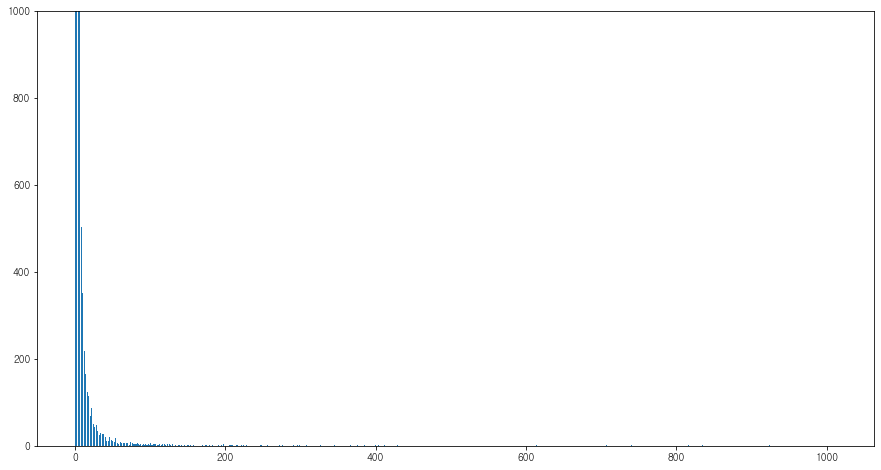

In [18]:
xaxis = np.unique(v).tolist() # unique한 value list
yaxis = []                    # 각 value의 개수
for xaxi in xaxis:            # xaxis의 count 값들을 yaxis에 저장
  yaxis.append(v.count(xaxi))
plt.figure(figsize=(15,8))
plt.ylim(0,1000) 
plt.bar(xaxis, yaxis)

In [19]:
print('단어 동시출현 빈도의 평균 : {0}회'.format(s/len(count)))
print('단어 동시출현 빈도의 평균 : {0}회'.format(np.median(v)))

단어 동시출현 빈도의 평균 : 2.975044289594898회
단어 동시출현 빈도의 평균 : 1.0회


In [20]:
# 빈도 1~5 제거 후 계산
count = {key : value for key, value in count.items() if value >5}

s = 0
v = []
for value in count.values():
  v.append(value)
  s += value

print('단어 동시출현 빈도의 평균 : {0}회'.format(s/len(count)))
print('단어 동시출현 빈도의 중앙값 : {0}회'.format(np.median(v)))

단어 동시출현 빈도의 평균 : 20.125639482395425회
단어 동시출현 빈도의 중앙값 : 10.0회


* 최종 추출

In [21]:
count.get(("a", "b"),0) #a, b라는 key가 없을 때는 디폴트를 0으로 해라 

# value가 n 회이상인 것만 추출
count = {key : value for key, value in count.items() if value >= 80}
count

{('모', '일반'): 216,
 ('교체', '모'): 83,
 ('어금니', '일반'): 145,
 ('어금니', '치과'): 150,
 ('아이', '어금니'): 99,
 ('일반', '치과'): 138,
 ('아이', '치과'): 174,
 ('교정', '다음'): 96,
 ('감사', '교정'): 281,
 ('클리너', '혀'): 222,
 ('감사', '혀'): 94,
 ('감사', '클리너'): 81,
 ('맘', '모'): 103,
 ('감사', '모'): 106,
 ('교정', '치아'): 406,
 ('교정', '만족'): 527,
 ('가격', '만족'): 391,
 ('어금니', '잇몸'): 126,
 ('교정', '일반'): 429,
 ('교정', '구입'): 707,
 ('만족', '제품'): 471,
 ('잇몸', '제품'): 168,
 ('어금니', '제품'): 83,
 ('만족', '잇몸'): 158,
 ('만족', '어금니'): 154,
 ('사랑니', '어금니'): 104,
 ('교정', '아들'): 390,
 ('교정', '주문'): 740,
 ('교정', '치과'): 1012,
 ('주문', '치과'): 367,
 ('교정', '아이'): 924,
 ('교정', '선택'): 85,
 ('만족', '주문'): 224,
 ('교정', '교정기'): 191,
 ('교정', '필요'): 376,
 ('교정', '미세모'): 386,
 ('감사', '만족'): 111,
 ('모', '잇몸'): 614,
 ('구입', '잇몸'): 91,
 ('구입', '모'): 195,
 ('교정', '딸'): 327,
 ('교정', '딸아이'): 215,
 ('치과', '판매'): 81,
 ('구입', '치과'): 404,
 ('만족', '아이'): 183,
 ('안쪽', '어금니'): 217,
 ('만족', '솔'): 113,
 ('만족', '모'): 306,
 ('솔', '일반'): 85,
 ('모', '솔'): 209,
 ('미세모', '

### 2. 저장  -  [단어1, 단어2, 빈도수] 로 데이터프레임 전처리하기

In [22]:
df1=pd.DataFrame.from_dict(count, orient='index')   # 동시출현빈도(dictionary)를 데이터프레임화
df1['keyword'] = df1.index
df1['freq'] = df1[0]
df1 = df1.drop([0], axis=1)

In [23]:
df1.columns

Index(['keyword', 'freq'], dtype='object')

In [24]:
df1[:10]

,keyword,freq
"(모, 일반)","(모, 일반)",216
"(교체, 모)","(교체, 모)",83
"(어금니, 일반)","(어금니, 일반)",145
"(어금니, 치과)","(어금니, 치과)",150
"(아이, 어금니)","(아이, 어금니)",99
"(일반, 치과)","(일반, 치과)",138
"(아이, 치과)","(아이, 치과)",174
"(교정, 다음)","(교정, 다음)",96
"(감사, 교정)","(감사, 교정)",281
"(클리너, 혀)","(클리너, 혀)",222


In [25]:
df1['keyword'][0]

('모', '일반')

In [26]:
list1=[]
for i in range(len(df1)):
    #index를 중심으로 계속 중첩해서 list에 넣는다 
    list1.append([df1['keyword'][i][0],df1['keyword'][i][1],df1['freq'][i]])

df2=pd.DataFrame(list1, columns=["keyword1","keyword2","freq"]).sort_values(by=['freq'],ascending=False)

In [27]:
df1.head()

,keyword,freq
"(모, 일반)","(모, 일반)",216
"(교체, 모)","(교체, 모)",83
"(어금니, 일반)","(어금니, 일반)",145
"(어금니, 치과)","(어금니, 치과)",150
"(아이, 어금니)","(아이, 어금니)",99


In [28]:
df2.head()

,keyword1,keyword2,freq
28,교정,치과,1012
30,교정,아이,924
64,교정,모,835
134,모,슬림,816
27,교정,주문,740


### 3. 네트워크 시각화

In [29]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


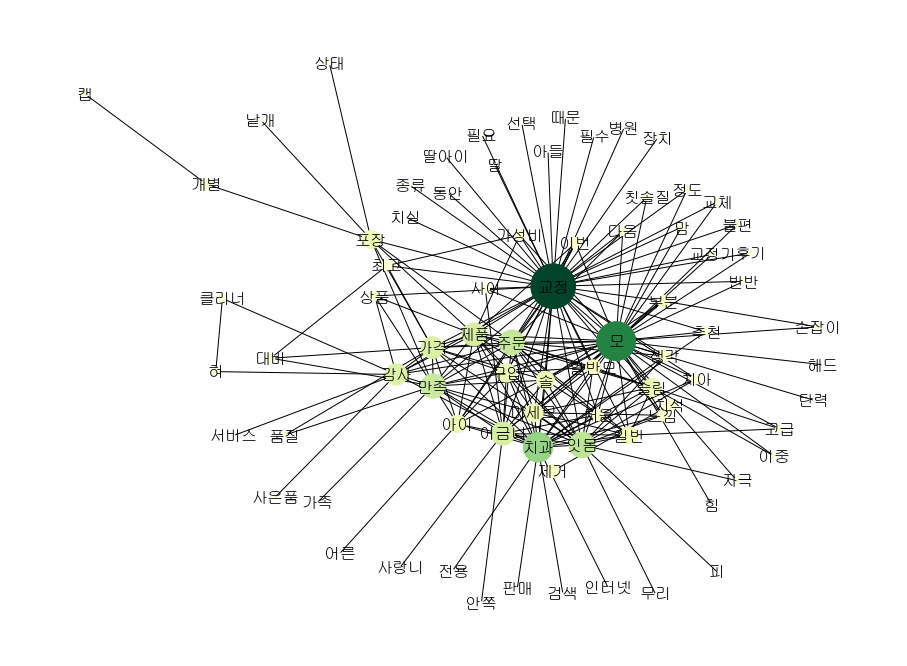

In [30]:
G = nx.Graph()
plt.figure(figsize=(16,12))
plt.axis('off') 
G.add_edges_from(df1['keyword'])                     # 노드에 들어갈 단어들
pr = nx.pagerank(G)                                 # 단어들 간 순위 매기기
nsize = np.array([v for v in pr.values()])          # 순위를 array로 변환
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
pos = nx.kamada_kawai_layout(G)                     # 노드 표현 방식
nx.draw_networkx(G, font_family=font_name,font_size=16, pos=pos, node_color = list(pr.values()), node_size=nsize,
                 cmap=plt.cm.YlGn,)
# plt.show()
plt.savefig('./칫솔 - 네트워크분석.jpeg')            # 이미지 저장이나 show 둘 중 하나만 실행가능하니, 저장할때는 show를 주석처리할것

### 4. 넷마이너 이용하기 위해 전처리

#### 일정빈도수 이상 언급된 단어만 따로 column 생성

In [31]:
# 이전 저장했던 토큰들을 딕셔너리에 count하여 넣기
word_count={}

for words in word_list:         
    for i in words:
        if i not in word_count: # 딕셔너리에 키값이 저장되있지 않으면 생성
            word_count[i] = 1
        else:
            word_count[i] += 1
word_count

{'일반': 866,
 '슬림형': 76,
 '교체': 378,
 '모': 3947,
 '이상': 108,
 '어금니': 1759,
 '치과': 3181,
 '아이': 2030,
 '관리': 223,
 '강추': 188,
 '저번': 201,
 '교정': 7068,
 '개운': 102,
 '다음': 639,
 '혀': 272,
 '클리너': 223,
 '감사': 1833,
 '기존': 274,
 '시스테마': 2,
 '등': 37,
 '이곳': 67,
 '맘': 757,
 '해외': 2,
 '종이': 10,
 '박스': 136,
 '커버': 40,
 '가족': 613,
 '이거': 362,
 '사요': 102,
 '치아': 727,
 '전용': 194,
 '만족': 3674,
 '가격': 2576,
 '모델': 14,
 '건데': 185,
 '잇몸': 1770,
 '타입': 36,
 '차이점': 9,
 '발견': 38,
 '나이': 11,
 '치주염': 7,
 '위험': 3,
 '증가': 1,
 '때문': 285,
 '엄': 4,
 '청': 9,
 '시중': 103,
 '정도': 320,
 '세기': 10,
 '프라그': 10,
 '슬림': 639,
 '모로': 104,
 '다량': 12,
 '구입': 1641,
 '가지': 235,
 '임': 28,
 '플란트': 26,
 '초미세모': 54,
 '부모': 120,
 '헤드': 359,
 '선호': 22,
 '제품': 3198,
 '마모': 81,
 '차이': 128,
 '아무거': 8,
 '사랑니': 149,
 '칫솔질': 419,
 '매각': 21,
 '예용': 10,
 '캡': 288,
 '거그': 1,
 '포장': 1120,
 '비닐': 10,
 '애': 222,
 '요청': 18,
 '도착': 117,
 '솟': 8,
 '모도': 502,
 '와이프': 17,
 '금요일': 6,
 '주문': 2742,
 '수요일': 4,
 '아들': 472,
 '대신': 27,
 '걸로': 209,
 '선택': 18

In [32]:
# 데이터프레임화
word_count_df = pd.DataFrame(list(word_count.items()),columns=['keyword', 'count'])
word_count_df

,keyword,count
0,일반,866
1,슬림형,76
2,교체,378
3,모,3947
4,이상,108
...,...,...
4020,바깥,1
4021,앙지,1
4022,기오,1
4023,고와,1


In [33]:
# 빈도수 기준으로 단어 제거 위함
count = word_count_df[word_count_df['count'] >= 40]  # 빈도수 40개 이상
count_list = list(count['keyword'])
len(count_list)

282

In [34]:
word_list

[['일반', '슬림형', '교체', '모', '이상'],
 ['어금니', '일반', '치과', '아이', '관리', '강추', '강추'],
 ['저번', '교정', '개운', '다음', '혀', '클리너', '감사'],
 ['모', '기존', '시스테마', '등', '이곳', '맘', '해외', '종이', '박스', '커버', '감사'],
 ['가족', '이거', '사요', '강추'],
 ['치아', '교정', '교정', '전용', '만족'],
 ['가격', '만족', '모델', '모델', '건데'],
 ['어금니', '슬림형', '잇몸', '타입', '차이점', '발견', '나이', '치주염', '위험', '증가'],
 ['치아', '때문', '감사'],
 ['엄', '청', '시중', '정도', '세기', '프라그', '만족', '슬림', '모로'],
 ['일반', '교정', '다량', '구입'],
 ['어금니', '가지', '차이점', '어금니', '일반', '임', '플란트'],
 ['초미세모', '부모'],
 ['헤드',
  '선호',
  '제품',
  '헤드',
  '만족',
  '잇몸',
  '마모',
  '위험',
  '부모',
  '초미세모',
  '임',
  '플란트',
  '부모',
  '어금니',
  '가지',
  '타입',
  '차이',
  '아무거'],
 ['사랑니', '어금니', '만족', '헤드'],
 ['칫솔질', '감사'],
 ['매각', '예용', '어금니', '캡'],
 ['거그', '포장', '다음', '비닐', '애', '요청'],
 ['포장', '도착', '솟', '모도'],
 ['포장', '도착', '모도'],
 ['와이프'],
 [],
 ['저번', '맘'],
 [],
 ['금요일', '주문', '수요일', '도착'],
 ['금요일', '주문', '수요일', '도착'],
 ['아들', '교정', '주문', '치과'],
 ['교정', '대신', '아이', '걸로', '선택'],
 ['교정기', '사이사이'],
 ['

In [35]:
cleared_list = []

list1 = []

# 불용어(stopwords)에 해당하는 요소 제외 -> list1
for word in word_list:
    li_1 = []
    for w in word:
        if w not in stop_words:
           li_1.append(w)
    list1.append(li_1)

# 빈도수 기준(count_list) 충족하는 요소 추출 -> cleared_list
for li in list1:
    li_2 = []
    for l in li:
        if l in count_list:
            li_2.append(l)
    cleared_list.append(li_2)

In [36]:
cleared_list

[['일반', '슬림형', '교체', '모', '이상'],
 ['어금니', '일반', '치과', '아이', '관리', '강추', '강추'],
 ['저번', '교정', '개운', '다음', '혀', '클리너', '감사'],
 ['모', '기존', '이곳', '맘', '박스', '커버', '감사'],
 ['가족', '이거', '사요', '강추'],
 ['치아', '교정', '교정', '전용', '만족'],
 ['가격', '만족', '건데'],
 ['어금니', '슬림형', '잇몸'],
 ['치아', '때문', '감사'],
 ['시중', '정도', '만족', '슬림', '모로'],
 ['일반', '교정', '구입'],
 ['어금니', '가지', '어금니', '일반'],
 ['초미세모', '부모'],
 ['헤드', '제품', '헤드', '만족', '잇몸', '마모', '부모', '초미세모', '부모', '어금니', '가지', '차이'],
 ['사랑니', '어금니', '만족', '헤드'],
 ['칫솔질', '감사'],
 ['어금니', '캡'],
 ['포장', '다음', '애'],
 ['포장', '도착', '모도'],
 ['포장', '도착', '모도'],
 [],
 [],
 ['저번', '맘'],
 [],
 ['주문', '도착'],
 ['주문', '도착'],
 ['아들', '교정', '주문', '치과'],
 ['교정', '아이', '걸로', '선택'],
 ['교정기', '사이사이'],
 ['선물', '혀', '클리너'],
 ['만족', '주문'],
 ['만족', '주문', '건데', '주문'],
 ['아이', '교정기', '교정', '필요', '미세모', '아이'],
 ['헤드'],
 ['만족', '주문', '남편', '세모', '가지', '주문', '게요'],
 ['색상', '감사', '번창'],
 ['이것저것', '차이'],
 [],
 ['만족'],
 ['맘'],
 ['맘', '가지', '종류', '차이', '어금니'],
 ['만족'],
 [],
 ['만족', '감사'

In [37]:
df['cleared_token'] = cleared_list

In [38]:
df

,내용,날짜,별점,재구매,한달사용기,종류,tokens,all_tokens,cleared_token
0,일반형은 확실히 뻣뻣하구요 슬림형이 부드럽구 좋아요 전 한달만사용하구 바로바로 교체...,2019-07-03,4,0,1,3,"['일반', '슬림형', '교체', '모', '이상']","['일반', '은', '확실히', '뻣뻣', '하', '구요', '슬림형', '부드...","[일반, 슬림형, 교체, 모, 이상]"
1,어금니일반형 우연히치과에서 써보구좋아 찾아보니 파네요 아이들 이관리해주기 딱좋은 ...,2019-07-04,5,0,0,4,"['어금니', '일반', '치과', '아이', '관리', '강추', '강추']","['어금니', '일반', '우연히', '치과', '에서', '써', '보', '좋'...","[어금니, 일반, 치과, 아이, 관리, 강추, 강추]"
2,저번에 구매 하였다가 잃어버려서 다시 구매 하였어요! 교정중인데 구석구석 잘 닦이구...,2019-07-08,5,1,0,4,"['저번', '교정', '개운', '다음', '혀', '클리너', '감사']","['저번', '에', '하', '였', '다가', '잃어버려서', '다시', '하'...","[저번, 교정, 개운, 다음, 혀, 클리너, 감사]"
3,칫솔모가 가늘면서도 짱짱해요^^ 기존엔 시스테마등을 사용했는데 전 이곳 칫솔이 훨씬...,2019-07-09,5,0,0,1,"['모', '기존', '시스테마', '등', '이곳', '맘', '해외', '종이'...","['모', '가', '가늘', '면서', '도', '짱짱', '해요', '^^', ...","[모, 기존, 이곳, 맘, 박스, 커버, 감사]"
4,온가족의 이를 책임지네요ㅎㅎ 이거써본후로는 여기서만 사요 강추,2019-07-14,5,0,0,2,"['가족', '이거', '사요', '강추']","['온', '가족', '의', '를', '책임지', '네요', 'ㅎㅎ', '이거',...","[가족, 이거, 사요, 강추]"
...,...,...,...,...,...,...,...,...,...
44955,헤드가 좀 크지만 좋아요,2022-05-09,5,0,0,4,['헤드'],"['헤드', '가', '좀', '크', '지만', '좋', '아요']",[헤드]
44956,배송빠릅니다 물건좋습니다,2022-05-09,5,0,0,2,['물건'],"['빠릅니다', '물건', '좋', '습니다']",[물건]
44957,중학교 다니는 애가 최근에 교정해서 구입해 사용중인데 만족합니다.,2022-05-09,5,0,1,1,"['중학교', '애', '최근', '교정', '구입', '만족']","['중학교', '다니', '는', '애', '가', '최근', '에', '교정', ...","[애, 교정, 구입, 만족]"
44958,배송도 빠르고 저렴한 가격으로 좋아요,2022-05-09,4,0,0,3,['가격'],"['도', '빠르', '고', '저렴', '한', '가격', '으로', '좋', '...",[가격]


In [39]:
# 한번 저장하지않으면 이후 처리가 실행이 안된다....
df.to_csv('./네트워크만들기1.csv') 

#### 언급 빈도수에 따른 매트릭스 만들기

In [40]:
import nltk
from nltk import ConditionalFreqDist
from nltk.util import ngrams

In [41]:
# 단어 제거한 파일 저장 후에 한번더 불러와야 코드 정상작동함 (전처리 부분에 저장코드 있음)
df = pd.read_csv('./네트워크만들기1.csv')

In [42]:
words = []
bigram = []
token =[]

# 빈 리스트 제거 후에 처리 시작(안하면 token += 부분에서 오류)
df = df.replace('[]',np.nan)
df = df.dropna(how = 'any')

for i in df['cleared_token']:
    # print(i)
    a = ast.literal_eval(i)
    words.append(a)

# # 단어 두 개씩 조합
for word in words:
    # print(word)
    bigrams = ngrams(word,2)
    bigram.append(bigrams)

for i in bigram:
  token += ([x for x in i])

cfd = ConditionalFreqDist(token)
cfd.conditions()

['일반',
 '슬림형',
 '교체',
 '모',
 '어금니',
 '치과',
 '아이',
 '관리',
 '강추',
 '저번',
 '교정',
 '개운',
 '다음',
 '혀',
 '클리너',
 '기존',
 '이곳',
 '맘',
 '박스',
 '커버',
 '가족',
 '이거',
 '사요',
 '치아',
 '전용',
 '가격',
 '만족',
 '때문',
 '시중',
 '정도',
 '슬림',
 '가지',
 '초미세모',
 '헤드',
 '제품',
 '잇몸',
 '마모',
 '부모',
 '사랑니',
 '칫솔질',
 '포장',
 '도착',
 '주문',
 '아들',
 '걸로',
 '교정기',
 '선물',
 '건데',
 '필요',
 '미세모',
 '남편',
 '세모',
 '색상',
 '감사',
 '이것저것',
 '종류',
 '차이',
 '신경',
 '피',
 '시간',
 '성인',
 '크기',
 '이번',
 '어른',
 '완전',
 '안',
 '탄력',
 '구입',
 '딸',
 '판매',
 '안쪽',
 '마음',
 '솔',
 '이후',
 '어린이',
 '굿',
 '내요',
 '부분',
 '모도',
 '엄마',
 '사은품',
 '우리',
 '집',
 '지난번',
 '구석',
 '생각',
 '검색',
 '다양',
 '처음',
 '손잡이',
 '가성비',
 '사이사이',
 '음식물',
 '서비스',
 '치실',
 '디자인',
 '컬러',
 '살',
 '첨',
 '세',
 '치석',
 '색깔',
 '딸아이',
 '병원',
 '품질',
 '심플',
 '지금',
 '마트',
 '낱개',
 '사이',
 '사람',
 '뒤',
 '상태',
 '모양',
 '개별',
 '건강',
 '일반모',
 '반반',
 '개당',
 '뚜껑',
 '모로',
 '사이즈',
 '길이',
 '보통',
 '기대',
 '이용',
 '대비',
 '주일',
 '이것',
 '무리',
 '조아',
 '최고',
 '기분',
 '유지',
 '장치',
 '구분',
 '추천',
 '만큼',
 '느낌',
 '케이스',
 '강도',
 

In [43]:
freq_matrix = []

for i in cfd.keys():
  temp = []
  for j in cfd.keys():
    temp.append(cfd[i][j])
  freq_matrix.append(temp)
freq_matrix = np.array(freq_matrix)

df = pd.DataFrame(freq_matrix, index = cfd.keys(), columns = cfd.keys())
#df.style.background_gradient(cmap='coolwarm')

In [44]:
df

,일반,슬림형,교체,모,어금니,치과,아이,관리,강추,저번,...,전체,쓰레기,수고,수량,도움,리필,대왕,닥터스,뇌물,파스텔
일반,15,13,1,43,27,22,6,2,0,0,...,0,0,0,0,1,0,1,0,1,0
슬림형,12,2,1,7,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
교체,2,0,5,5,1,7,2,2,0,0,...,0,0,0,0,1,0,0,0,0,0
모,30,2,20,118,48,52,34,1,5,2,...,2,0,0,1,1,0,0,0,0,0
어금니,39,7,1,21,44,11,7,38,4,0,...,4,0,0,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
리필,0,0,2,0,0,0,1,0,1,0,...,0,5,0,0,1,0,0,0,0,0
대왕,1,0,0,2,1,1,0,0,1,0,...,0,0,0,0,0,1,1,0,1,0
닥터스,0,0,0,0,1,16,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
뇌물,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


#### 넷마이너 import용 데이터 생성

In [45]:
df.to_csv('./네트워크 분석용.csv', encoding = 'utf-8-sig')